# Profils de succion et drainage latéral dans les barrières capillaires

Pour exécuter une cellule, `Ctrl + Enter`. Pour exécuter une cellule et passer à la suivante, `Maj. + Enter`. Pour exécuter toute la feuille, dans le menu `Cell`, sélectionner `Run All`.

## Charger les librairies

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.integrate import quad
from scipy.interpolate import interp1d

## Modèles hydrauliques

Les propriétés hydrauliques des milieux poreux non saturés peuvent être décrite par leurs propriétés de rtention d'eau et de conductivité hydraulique. Le modèle de van Genuchten (1980) sera utilisé.

### Courbe de rétention d'eau, van Genuchten (1980):
\begin{align}
\theta(\psi)  = \theta_{r} + (\theta_{s} - \theta_{r})  (1+(a_{VG}  \psi)^{n_{VG}})^{-m_{VG}} \\
\end{align}

### Fonction de conductivité hydraulique, van Genuchten et al. (1991), basé sur van Genuchten (1980) et Mualem (1976):
\begin{align}
k(\psi) = k_{sat}  \frac {(1-((a_{VG}  \psi)^{n_{VG}m_{VG}})  (1+(a_{VG} \psi)^{n_{VG}})^{-m_{VG}}))^2} { (1+(a_{VG} \psi)^{n_{VG}})^{m_{VG}l_{VG}}}
\end{align}

In [2]:
def vanGenuchten(thR, thS, aVG, nVG, mVG, ksat, psi, lVG=0.5):
    th = thR + (thS - thR) * (1+(aVG * psi) ** nVG) ** (-mVG)
    k = ksat*((1-((aVG*psi)**(nVG*mVG))* \
        ((1+((aVG*psi)**nVG))**(-mVG)))**2) / \
        ((1+((aVG*psi)**nVG))**(mVG*lVG))
    return(pd.DataFrame({'psi':psi, 'theta':th, 'k':k}))

Une barrière capillaire inclut une couche de bris capillaire (capillary break layer, CBL) sur laquelle est installée une couche de rétention capillaire (moisture retaining layer, MRL). Définissons les paramètres de van Genuchten pour la CBL et la MRL.

In [3]:
# CBL
cbl_thR = 0.017
cbl_thS = 0.37
cbl_aVG = 3.5 * 9.807 # 9.807 pour exprimer en 1/m des valeurs exprimées en 1/kPa
cbl_nVG = 3.0
cbl_mVG = 1 - 1/cbl_nVG
cbl_lVG = 0.5
cbl_ksat = 2.3e-3 # m/s

# MRL
mrl_thR = 0.1
mrl_thS = 0.4
mrl_aVG = 1.8 * 9.807 # 9.807 pour exprimer en 1/m des valeurs exprimées en 1/kPa
mrl_nVG = 1.3
mrl_mVG = 1 - 1/mrl_nVG
mrl_lVG = 0.5
mrl_ksat = 3e-4 # m/s

Nous aurons aussi besoin de vecteurs `psi` pour indiquer à notre fonction `vanGenuchten` sur quelles valeurs de succion (en mètres) les valeurs de teneur en eau et de conductivité hydraulique devraient être calculées.


In [4]:
npoints = 1000
cbl_psi = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)
mrl_psi = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)

Entrons ces paramètres dans la fonction `vanGenuchten`.

In [5]:
cbl_VG = vanGenuchten(thR=cbl_thR, thS=cbl_thS, aVG=cbl_aVG, nVG=cbl_nVG,
                  mVG=cbl_mVG, ksat=cbl_ksat, psi=cbl_psi, lVG=cbl_lVG)
mrl_VG = vanGenuchten(thR=mrl_thR, thS=mrl_thS, aVG=mrl_aVG, nVG=mrl_nVG,
                  mVG=mrl_mVG, ksat=mrl_ksat, psi=mrl_psi, lVG=mrl_lVG)

Comme on l'a demandé dans la fotion `vanGenuchten`, la sortie de la fonction est un tableau (de type `pandas` `DataFrame`). Voyons voir l'entête de `cbl_VG` par exemple.

In [6]:
cbl_VG.head()

,k,psi,theta
0,0.001779,0.010000,0.360793
1,0.001770,0.010093,0.360543
2,0.001761,0.010186,0.360287
3,0.001752,0.010280,0.360024
4,0.001743,0.010376,0.359754


Créons un graphique des courbes de rétention d'eau ainsi que de la fonction de conductivité hydraulique.

NameError: name 'fontSize' is not defined

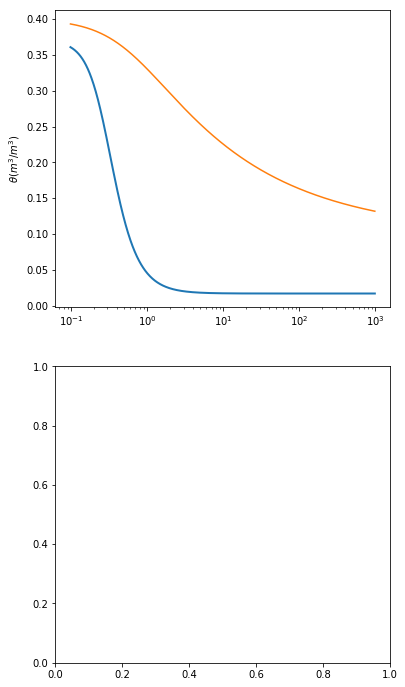

In [7]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))

# Courbe de rétention d'eau
## Décorations
axes[0].set_ylabel(r'$\theta (m^3/m^3)$')
axes[0].set_xscale('log')
axes[0].set_xticks([0.1, 1, 10, 100, 1000])
## Graphique
axes[0].plot(cbl_VG.psi * 9.807, cbl_VG.theta, linewidth=2, label="CBL material")
axes[0].plot(mrl_VG.psi * 9.807, mrl_VG.theta, label="MRL material")
legend = axes[0].legend(fontsize = fontSize * 0.8)
frame = legend.get_frame()
frame.set_facecolor('1.00')

# Fonction de conductivité hydraulique
## Décorations
axes[1].set_xlabel(r'$\psi (kPa)$')
axes[1].set_ylabel(r'$k (m/s)$')
axes[1].set_xscale('log')
axes[1].set_xticks([0.1, 1, 10, 100, 1000])
axes[1].set_yscale('log')
axes[1].set_ylim([1e-16, 1e-2])
## Graphique
axes[1].plot(cbl_VG.psi * 9.807, cbl_VG.k, linewidth=2, label="CBL material")
axes[1].plot(mrl_VG.psi * 9.807, mrl_VG.k, label="MRL material")

## Profil de succion dans une colonne de matériau poreux soumis à un débit unitaire

Une démonstration similaire a d'abord été publiée par Kisch (1959).

\begin{align}
q = k(\psi) \frac{dh}{dz}
\end{align}

\begin{align}
h = z + p = z - \psi
\end{align}

\begin{align}
q = k(\psi) \frac{dz - d\psi}{dz}
\end{align}

\begin{align}
q = k(\psi) (1 - \frac{d\psi}{dz})
\end{align}

\begin{align}
\frac {q}{k(\psi)} = 1 - \frac{d\psi}{dz}
\end{align}

\begin{align}
\frac{d\psi}{dz} = 1-\frac {q}{k(\psi)}
\end{align}

\begin{align}
dz = \frac{d\psi}{1-\frac {q}{k(\psi)}}
\end{align}

\begin{align}
z(\psi) = \int_{\psi_{min}}^{\psi} \frac{1}{1-\frac {q}{k(\psi)}}d\psi
\end{align}

L'intégrale peut être approximée par:
\begin{align}
z(\psi) = \sum_{i=1}^{n} \frac{\Delta\psi}{1-\frac {q}{k_n(\psi)}}
\end{align}

La fonction `kisch` est une manière parmi d'autres d'encoder cette fonction en Python:

In [8]:
def kisch(thR, thS, aVG, nVG, mVG, ksat, psi, q, lVG=0.5, psi_min=1e-3, z_min=0):
    model_init = vanGenuchten(thR=thR, thS=thS, aVG=aVG, nVG=nVG, mVG=mVG, ksat=ksat, lVG=lVG,
                    psi=psi)
    interp_func = interp1d(np.log10(model_init.k), np.log10(model_init.psi))
    psi_q = 10**interp_func(np.log10(q))
    model_kisch = vanGenuchten(thR=thR, thS=thS, aVG=aVG, nVG=nVG, mVG=mVG, ksat=ksat, lVG=lVG,
                           psi=np.logspace(start = np.log10(psi_min), stop = np.log10(psi_q),
                                    num = model_init.shape[0]))
    delta_psi_kisch = model_kisch.psi.diff().shift(-1)    
    z = (delta_psi_kisch / (1 - q/model_kisch.k)).cumsum() + z_min
    return(pd.DataFrame({'psi': model_kisch.psi, 'z':z}))

Par exemple, prenons un débit unitaire traversant une colonne du sol de la CBL ayant une succion de 0 kPa à sa base 

In [9]:
unit_flow=1e-8
cbl_kisch = kisch(thR=cbl_thR, thS=cbl_thS, aVG=cbl_aVG, nVG=cbl_nVG,
                  mVG=cbl_mVG, ksat=cbl_ksat, psi=cbl_psi, 
                  q=unit_flow, lVG=cbl_lVG, z_min=0)
cbl_kisch.head()

,psi,z
0,0.001000,0.000005
1,0.001005,0.000010
2,0.001010,0.000015
3,0.001015,0.000020
4,0.001020,0.000025


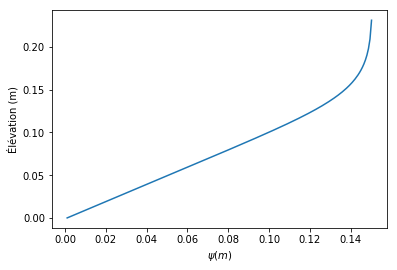

In [10]:
plt.plot(cbl_kisch.psi, cbl_kisch.z, '-')
plt.xlabel(r'$\psi (m)$')
plt.ylabel('Élévation (m)')

Le graphique montre que la succion augmente linéairement avec l'élévation, puis s'incurve pour converger vers une valeur d'environ 0.15 m.

In [11]:
cbl_kisch.psi.max()

0.1510629552887498

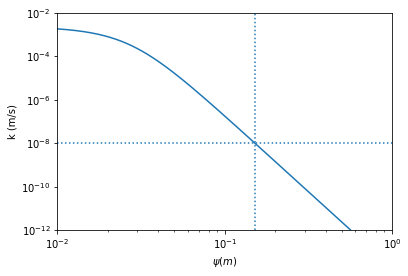

In [12]:
plt.plot(cbl_VG.psi, cbl_VG.k)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-2, 1])
plt.ylim([1e-12, 1e-2])
plt.xlabel(r'$\psi (m)$')
plt.ylabel('k (m/s)')
plt.axhline(unit_flow, ls=':')
plt.axvline(cbl_kisch.psi.max(), ls=':')

Il est possible de superposer une MRL en spécifiant son élévation et la valeur de succion à sa base (égale à la valeur maximale de succion de la CBL).

In [13]:
cbl_thickness = 0.3
mrl_kisch = kisch(thR=mrl_thR, thS=mrl_thS, aVG=mrl_aVG, nVG=mrl_nVG,
                  mVG=mrl_mVG, ksat=mrl_ksat, psi=mrl_psi, 
                  q=unit_flow, lVG=mrl_lVG, psi_min=cbl_kisch.psi.max(), z_min=cbl_thickness)

### Graphiques du profil de succion dans une barrière capillaire

In [14]:
cbl_kisch_VG = vanGenuchten(thR=cbl_thR, thS=cbl_thS, aVG=cbl_aVG, nVG=cbl_nVG,
                  mVG=cbl_mVG, ksat=cbl_ksat, psi=cbl_kisch.psi, lVG=cbl_lVG)
cbl_kisch_VG['z'] = cbl_kisch.z
mrl_kisch_VG = vanGenuchten(thR=mrl_thR, thS=mrl_thS, aVG=mrl_aVG, nVG=mrl_nVG,
                  mVG=mrl_mVG, ksat=mrl_ksat, psi=mrl_kisch.psi, lVG=mrl_lVG)
mrl_kisch_VG['z'] = mrl_kisch.z
mrl_kisch_VG.head()

,k,psi,theta,z
0,7.690200e-07,0.151063,0.311172,0.300259
1,7.659661e-07,0.151318,0.311089,0.300518
2,7.629234e-07,0.151574,0.311005,0.300777
3,7.598920e-07,0.151830,0.310921,0.301037
4,7.568717e-07,0.152086,0.310838,0.301297


Pour s'assurer une continuité entre la CBL et la MRL, ajoutons des points à l'interface.

In [15]:
interface_VG = pd.DataFrame({'k':cbl_kisch_VG.k.min(), 
                            'psi': cbl_kisch_VG.psi.max(),
                            'theta': cbl_kisch_VG.theta.min(),
                            'z': cbl_thickness},
                           index=['interface'])

In [16]:
kisch_VG = pd.concat([cbl_kisch_VG, interface_VG, mrl_kisch_VG]).dropna(axis=0)

Posons une épaisseur de MRL pour la limite supérieure du grahique.

In [17]:
mrl_thickness = 0.8
kisch_VG = kisch_VG.loc[kisch_VG.z <= (cbl_thickness + mrl_thickness), :]

NameError: name 'fontSize' is not defined

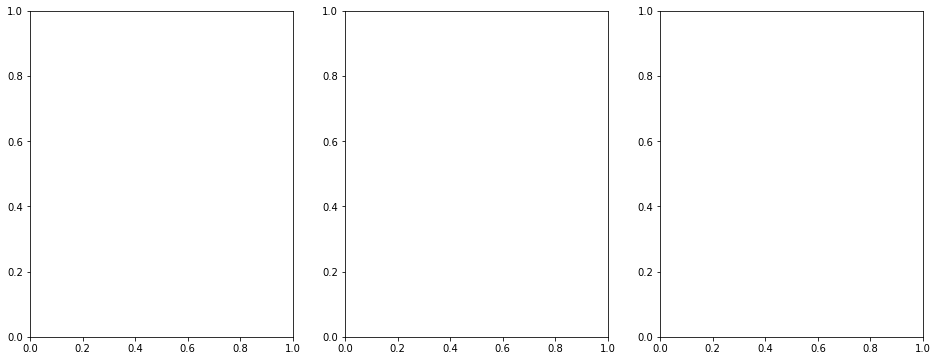

In [18]:
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

# Suction profile
axes[0].set_xlabel(r'$\psi (kPa)$', fontsize = fontSize)
axes[0].set_ylabel(r'$Elevation (m)$', fontsize = fontSize)
axes[0].axhline(cbl_thickness, linestyle=':')
axes[0].plot(kisch_VG.psi * 9.807, kisch_VG.z, linestyle='-')

# WC profile
axes[1].set_xlabel(r'$\theta (kPa)$', fontsize = fontSize)
axes[1].yaxis.set_visible(False)
axes[1].axhline(cbl_thickness, ls=':')
axes[1].plot(kisch_VG.theta, kisch_VG.z, linestyle='-')

# k profile
axes[2].set_xlabel(r'$k (m/s)$', fontsize = fontSize)
axes[2].yaxis.set_visible(False)
axes[2].set_xscale('log')
axes[2].axhline(cbl_thickness, linestyle=':')
axes[2].plot(kisch_VG.k, kisch_VG.z, linestyle='-')

## Drainage latéral dans une barrière capillaire inclinée

Ross (1990) décrit le modèle suivant.

\begin{align}
Q_{max} = \tan(\phi) \int_{\psi_{CBC}}^{\psi_{CRC}} k(\psi) d\psi \\
L = \frac {Q_{max}}{q}
\end{align}

In [19]:
def k_vanGenuchten(x, aVG, nVG, mVG, ksat, lVG = 0.5):
        k = ksat * ((1 - ((aVG * x)**(nVG * mVG)) * \
        ((1 + ((aVG * x)**nVG))**(-mVG)))**2) / \
        ((1 + ((aVG * x)**nVG))**(mVG * lVG))
        return(k)

### Capacité et longueur de transfert

In [20]:
pente = 0.25

Qmax = pente * quad(k_vanGenuchten, # fonction
                    cbl_kisch.psi.max(), mrl_kisch.psi.max(), # bornes
                    args=(mrl_aVG, mrl_nVG, mrl_mVG, mrl_ksat, mrl_lVG))[0] # arguments de la fonction
L = Qmax / unit_flow

print ('Le débit de transfert maximal dans la barrière capillaire est de', Qmax, 'm²/s.')
print ('La longueur de transfert maximale dans la barrière capillaire est de', L, 'm.')

Le débit de transfert maximal dans la barrière capillaire est de 1.7927827356255177e-08 m²/s.
La longueur de transfert maximale dans la barrière capillaire est de 1.7927827356255177 m.


### Épaisseur minimale de la CBL

In [21]:
cbl_kisch.psi.max()

0.1510629552887498

### Épaisseur de la couche de rétention capillaire (CRC ou MRL)

In [22]:
mrl_psi = np.linspace(start = cbl_kisch.psi.max(), stop = mrl_kisch.psi.max(), num = 20, endpoint = True) 
mrl_thickness = mrl_psi - cbl_kisch.psi.max()
Qmax_thickness = np.array([])
for i in range(0, len(mrl_psi)):
    Qmax_thickness = np.append(Qmax_thickness, pente * quad(k_vanGenuchten, cbl_kisch.psi.max(), mrl_psi[i], args=(mrl_aVG, mrl_nVG, mrl_mVG, mrl_ksat, mrl_lVG))[0])

L_thickness = Qmax_thickness / unit_flow
Qmax_thickness

array([  0.00000000e+00,   5.25578662e-09,   8.56432869e-09,
         1.07881198e-08,   1.23584607e-08,   1.35109193e-08,
         1.43832318e-08,   1.50604249e-08,   1.55973636e-08,
         1.60307780e-08,   1.63860351e-08,   1.66811266e-08,
         1.69291111e-08,   1.71396597e-08,   1.73200628e-08,
         1.74759044e-08,   1.76115215e-08,   1.77303262e-08,
         1.78350337e-08,   1.79278274e-08])

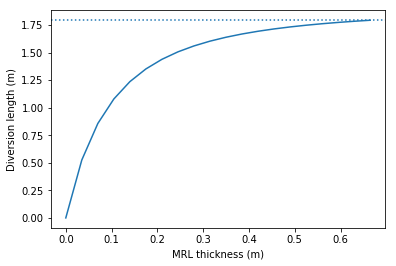

In [23]:
plt.axhline(L, linestyle=':')
plt.plot(mrl_thickness, L_thickness)
plt.xlabel('MRL thickness (m)')
plt.ylabel('Diversion length (m)')